# Machine learning using EKF

In [1]:
from IPython import display
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

# Importing Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim

In [2]:
# Select data directory
print("Current Directory:",os.getcwd())
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('..\data/'):
    course_data_dir = '..\data'
else:
    # Specify course_data_dir on your machine
    # course_data_dir = ...
    # YOUR CODE HERE
    raise NotImplementedError()

print('The data directory is %s' % course_data_dir)

Current Directory: D:\From Web\STUDIES\EKF
The data directory is \EKF


In [3]:
# Select device which you are going to use for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Import Data Sets
Testing using a toy sine data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Min-max scaling to [-1, 1]
])

data_dir = os.path.join(course_data_dir, 'fashion_mnist')
print('Data stored in %s' % data_dir)
trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Data stored in \EKF\fashion_mnist


In [5]:
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)

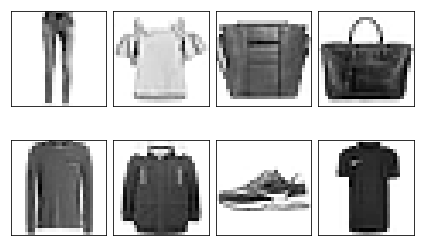

In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
plot_images(images[:8], n_rows=2)

## Data Preprocessing


In [7]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

## Define Neural network

In [8]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden_layer,n_outputs,bias=True):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(n_inputs,n_hidden_layer, bias)
        self.fc2 = nn.Linear(n_hidden_layer, n_outputs ,bias)

        

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = (self.fc2(x))
        return x

In [9]:
## Testing net
n_inputs = 784
n_outputs = 16
n_hidden_layer = 32
test_net = MLP(n_inputs, n_hidden_layer,n_outputs)
test_net.to(device)
# print(test_net)

MLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(test_net.parameters(), lr=0.001, momentum=0.9)

In [11]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    test_net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            #print(images.size())
            outputs = test_net(images.view(-1,784))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
n_epochs=10
for epoch in range(n_epochs):
    running_loss = 0.0
    print_every = 200  # mini-batches
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Transfer to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs= torch.tensor(inputs,device=device,dtype=torch.double)
        #print(inputs.size())
        inputs=inputs.view(-1,784)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = test_net(inputs)
#         print(outputs.size())
#         print(labels.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0
#         if skip_training:
#             break

#     # Print accuracy after every epoch
    accuracy = compute_accuracy(test_net, testloader)
    print('Accuracy of the network on the test images: %.3f' % accuracy)

# #     if skip_training:
# #         break

print('Finished Training')

## Using EKF for learning 

In [21]:
# #Calculate Weight size
# weight_mat_size = 0
# for i in range(len(layer_list)-1):
#     weight_mat_size = weight_mat_size + (layer_list[i]*layer_list[i+1])
        
def getWeights(net):
    weight_mat = []
    for name,param in net.named_parameters():
    
        #print('Layer',name, 'is', param.data.shape)
        if (len(list(param.data.shape)) == 2):
            weight_mat.append(param.data.flatten())
        
    weight_mat = torch.cat(weight_mat, dim=0)       
    #print('Shape of weight matrix', weight_mat.shape)
    return weight_mat.view(-1, 1)

def getWeightsgrad(net):
    weight_grad_mat = []
    for name,param in net.named_parameters():
    
        #print('Layer Grads',name, 'is', param.grad.shape)
        if (len(list(param.grad.shape)) == 2):
            weight_grad_mat.append(param.grad.flatten())
        
    weight_grad_mat = torch.cat(weight_grad_mat, dim=0)       
    #print('Shape of weight matrix', weight_grad_mat.shape)   
    return weight_grad_mat.view(-1, 1)

def setWeights(net, weight_mat):
    mem_ind = 0;
    for name,param in net.named_parameters():
        if (len(list(param.data.shape)) == 2):
            #print('Layer',name, 'is', param.data.shape)
            #print(torch.numel(param.data))
            #print(weight_mat[mem_ind:mem_ind+torch.numel(param.data)].view(param.data.shape).shape)
            param.data = weight_mat[mem_ind:mem_ind+torch.numel(param.data)].view(param.data.shape)
            mem_ind = torch.numel(param.data)
    


In [26]:
# Define number of Input and Output layers
device='cpu'
torch.set_default_dtype(torch.float32)
n_inputs = 784
n_outputs=10
batch_size=10
n_hidden_layer = 10
mlp_EKF = MLP(n_inputs,n_hidden_layer,n_outputs,bias = False)
mlp_EKF = mlp_EKF.to(device)
n_epochs = 1

print("Printing network",mlp_EKF)

# Define EKF covariances
#weight_mat = getWeights(mlp_EKF).to(device)
# System Noise or also known as training  noise  

Q = 1e-6*torch.eye((getWeights(mlp_EKF).shape[0]),device=device, dtype=torch.float32)
# Measurement noise or noise in targets / Learning rate
R = 10*torch.eye(batch_size*n_outputs,device=device, dtype=torch.float32)
#Covariance Matrix
P = 100*torch.eye((getWeights(mlp_EKF).shape[0]),device=device, dtype=torch.float32)
print(P.size())

#print(weight_mat.shape)
#print(x_train.shape)
#print(y_train.shape)

Printing network MLP(
  (fc1): Linear(in_features=784, out_features=10, bias=False)
  (fc2): Linear(in_features=10, out_features=10, bias=False)
)
torch.Size([7940, 7940])


In [27]:
def err_loss(outputs,labels):
    
    return (labels-outputs)


In [28]:
# def cross_err_loss(outputs,labels):
#     loss= torch.sqrt(-(labels*torch.log(outputs)+(torch.ones(labels.shape[0])-labels)*torch.log(torch.ones(labels.shape[0])-outputs)))
#     return loss     
cross_err_loss=nn.BCEWithLogitsLoss(reduction='none')
                    

In [29]:
#x_train = torch.tensor(x_train, device=device, dtype=torch.float64)
#y_train = torch.tensor(y_train, device=device, dtype=torch.float64)

#ceLoss = nn.MSELoss(reduction='none')

# Plotting before learning 
#fig, ax = plt.subplots(1)
#ax.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), '.')

n_epochs=10


for epoch in range(n_epochs):
    
    #outputs = [] 
    #Calling Backward for each sample
   
    for i,(inputs,labels) in enumerate(trainloader,0):
        loss=[]
        H=[]
        inputs, labels = inputs.to(device), labels.to(device)
        #print(labels)
        inputs= torch.tensor(inputs,device=device,dtype=torch.float32).view(-1,784)
        labels= torch.tensor(labels,device=device,dtype=torch.long)
        outputs = mlp_EKF(inputs)

        #outputs.append(output)
        #print("Update for Batch",i)
        mlp_EKF.zero_grad()
        #print(label_vector)
        #loss = criterion(outputs, labels)

        for i in range(outputs.shape[0]):
            label_vector=torch.zeros(outputs.shape[1]).to(device)
            label_vector[labels]=1
                
            #print(outputs[i].shape)
            #print(label_vector.shape)
            err=cross_err_loss(outputs[i],label_vector)
            #print(loss.size())
            loss.append(err) 
            for j in range(err.shape[0]):
                err[j].backward(retain_graph=True)
        
                H.append(getWeightsgrad(mlp_EKF).to(device).view(-1))
                
                
        loss=torch.cat(loss).view(-1,1)
        net_loss=torch.mean(loss)
        print('Net loss',net_loss)
        H=torch.stack(H,dim=0)
#         print(loss.shape)
#         print(H.size())
#         print(P.size())
        #print("Shape of Weight Grad Mat", H)
        #update weights using EKF filter Update
        Ak = torch.inverse(R + torch.mm(torch.mm(H, P), torch.transpose(H,0,1)))
        #print(Ak)
        #Ak = torch.ones(1).view(1,1).to(device)
        Kk = torch.mm(torch.mm(P, torch.transpose(H,0,1)), Ak)
        
        #Kk = torch.ones((120,1)).to(device)
        #print(weight_mat.shape)
        print("Shape of Kalman gain",Kk.shape)
        #print("Shape of loss",loss.shape)
        #print("Shape of mul term",torch.mm(Kk, loss).shape)
        #print("Weight Mat Shape",weight_mat)
        #print(loss)
        weight_mat= getWeights(mlp_EKF).to(device)
        weight_mat = weight_mat + torch.mm(Kk, loss)
        #print("Weight Mat Shape",weight_mat.shape)
        P = P + Q - torch.mm(torch.mm(Kk,H),P)
        setWeights(mlp_EKF,weight_mat)
        
    #print("Weight",weight_mat)
    #outputs = torch.cat(outputs, dim=0)
    
    #Plotting Output
#     ax.clear()
#     plt_x_train = inputs.cpu().detach().numpy()
#     plt_y_train = y_train.cpu().detach().numpy()
#     plt_outputs = outputs.cpu().detach().numpy()
#     ax.plot(plt_x_train, plt_y_train, '.')
#     ax.plot(plt_x_train, plt_outputs, 'r-')
#     ax.grid(True)
#     ax.set_title('Iteration %d/%d' % (epoch+1, n_epochs))
    display.clear_output(wait=True)
#     display.display(fig)
#     plt.pause(0.005)
    
# display.clear_output(wait=True)

C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(0.6950, grad_fn=<MeanBackward1>)
Shape of Kalman gain torch.Size([7940, 100])


C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(0.7222, grad_fn=<MeanBackward1>)
Shape of Kalman gain torch.Size([7940, 100])


C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(0.6562, grad_fn=<MeanBackward1>)
Shape of Kalman gain torch.Size([7940, 100])


C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(0.7987, grad_fn=<MeanBackward1>)
Shape of Kalman gain torch.Size([7940, 100])


C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(0.8291, grad_fn=<MeanBackward1>)
Shape of Kalman gain torch.Size([7940, 100])


C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(0.9729, grad_fn=<MeanBackward1>)
Shape of Kalman gain torch.Size([7940, 100])


C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(1.2394, grad_fn=<MeanBackward1>)
Shape of Kalman gain torch.Size([7940, 100])


C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(2.6476, grad_fn=<MeanBackward1>)
Shape of Kalman gain torch.Size([7940, 100])


C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(21.1095, grad_fn=<MeanBackward1>)
Shape of Kalman gain torch.Size([7940, 100])


C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Krishnananda Prabhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Net loss tensor(10519.1387, grad_fn=<MeanBackward1>)


RuntimeError: Lapack Error getrf : U(26,26) is 0, U is singular at c:\a\w\1\s\tmp_conda_3.6_104352\conda\conda-bld\pytorch_1550400396997\work\aten\src\th\generic/THTensorLapack.cpp:555

# Appendix